<div class="alert alert-block alert-info">

## <center> <b> Stock Sentiment </center>
## <center> Predicting market behavior from tweets </center> <br>
##  <center> <b> PREPROCESSING TESTING AND EXPLORATION </center> <br>
## <center> Spring Semester 2024-2025 <center>

<center> Group 35: <center>
<center>Joana Esteves, 20240746 <br><center>
<center>José Cavaco, 20240513 <br><center>
<center> Leonardo Di Caterina 20240485<br><center>
<center>Matilde Miguel, 20240549 <br><center>
<center>Rita Serra, 20240515 <br><center>

<div>

## Data Loading

In [1]:
import os # type: ignore
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
from wordcloud import WordCloud # type: ignore
from collections import Counter # type: ignore

# Load data
data_folder = os.path.join(os.path.dirname(os.getcwd()), 'data')
data_train = pd.read_csv(os.path.join(data_folder, 'train.csv'))
print(f"Dataset shape: {data_train.shape}")
data_train.head()

Dataset shape: (9543, 2)


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


## Setup Preprocessing

In [2]:
# Change to parent directory to import preprocessing
print("Current working directory:", os.getcwd())
os.chdir(os.path.dirname(os.getcwd()))
print("Changed working directory to:", os.getcwd())

Current working directory: /Users/joanaesteves/Desktop/MDSAA-DS/S2/T4/TM/TM_Project/Notebooks
Changed working directory to: /Users/joanaesteves/Desktop/MDSAA-DS/S2/T4/TM/TM_Project


In [3]:
from src.preprocessing import Preprocessing

Preprocessing_instance = Preprocessing(lemmatize=True, stem=False)

# Initialize preprocessing with different configurations
preprocessor_lemma = Preprocessing(lemmatize=True, stem=False, emoji_support_level=1)
preprocessor_stem = Preprocessing(lemmatize=False, stem=True, emoji_support_level=1)
preprocessor_both = Preprocessing(lemmatize=True, stem=True, emoji_support_level=1)

print("Preprocessing modules initialized")

/Users/joanaesteves/Desktop/MDSAA-DS/S2/T4/TM/.TM_Project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/joanaesteves/Desktop/MDSAA-DS/S2/T4/TM/.TM_Project/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:177: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Preprocessing modules initialized


## Raw Text Analysis

In [4]:
# Sample some texts for detailed analysis
sample_texts = data_train['text'].head(10).tolist()

print("Sample raw texts:")
for i, text in enumerate(sample_texts[:3], 1):
    print(f"\n{i}. {text[:200]}...")

Sample raw texts:

1. $BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT...

2. $CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3...

3. $CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb...


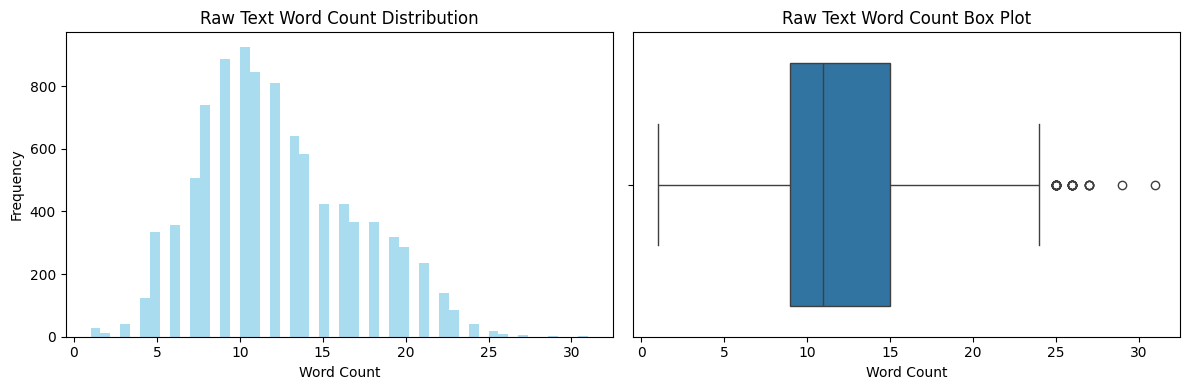

Raw text word count statistics:
count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count_raw, dtype: float64


In [5]:
# Word count analysis before preprocessing
data_train['word_count_raw'] = data_train['text'].apply(lambda x: len(str(x).split(" ")))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(data_train['word_count_raw'], bins=50, alpha=0.7, color='skyblue')
plt.title('Raw Text Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(x=data_train['word_count_raw'])
plt.title('Raw Text Word Count Box Plot')
plt.xlabel('Word Count')

plt.tight_layout()
plt.show()

print(f"Raw text word count statistics:")
print(data_train['word_count_raw'].describe())

## Preprocessing Comparison

In [6]:
# Test preprocessing on sample texts
test_texts = sample_texts[:5]

# Apply different preprocessing approaches
processed_lemma = preprocessor_lemma.preprocess(test_texts)
processed_stem = preprocessor_stem.preprocess(test_texts)
processed_both = preprocessor_both.preprocess(test_texts)

# Compare results
for i, (raw, lemma, stem, both) in enumerate(zip(test_texts, processed_lemma, processed_stem, processed_both), 1):
    print(f"\n=== Text {i} ===")
    print(f"Raw ({len(raw.split())} words): {raw[:100]}...")
    print(f"Lemmatized ({len(lemma)} tokens): {' '.join(lemma[:15])}...")
    print(f"Stemmed ({len(stem)} tokens): {' '.join(stem[:15])}...")
    print(f"Both ({len(both)} tokens): {' '.join(both[:15])}...")

Processing emojis with support level 1
ASCII cleaned text: TICKER   JPMorgan reels in expectations on Beyond Meat URL
Processing emojis with support level 1
ASCII cleaned text: TICKER TICKER   Nomura points to bookings weakness at Carnival and Royal Caribbean URL
Processing emojis with support level 1
ASCII cleaned text: TICKER   Cemex cut at Credit Suisse  JP  Morgan on weak building outlook URL
Processing emojis with support level 1
ASCII cleaned text: TICKER  BTIG Research cuts to Neutral URL
Processing emojis with support level 1
ASCII cleaned text: TICKER   Funko slides after Piper Jaffray PT cut URL
Processing emojis with support level 1
ASCII cleaned text: TICKER   JPMorgan reels in expectations on Beyond Meat URL
Processing emojis with support level 1
ASCII cleaned text: TICKER TICKER   Nomura points to bookings weakness at Carnival and Royal Caribbean URL
Processing emojis with support level 1
ASCII cleaned text: TICKER   Cemex cut at Credit Suisse  JP  Morgan on weak building

## Full Dataset Preprocessing Analysis

In [7]:
# Process a subset for analysis (first 1000 samples to avoid memory issues)
subset_size = 1000
subset_texts = data_train['text'].head(subset_size).tolist()

processed_subset = preprocessor_lemma.preprocess(subset_texts)

# Calculate token counts after preprocessing
token_counts = [len(tokens) for tokens in processed_subset]

print(f"\nToken count statistics after preprocessing:")
print(f"Mean: {np.mean(token_counts):.2f}")
print(f"Median: {np.median(token_counts):.2f}")
print(f"Min: {np.min(token_counts)}")
print(f"Max: {np.max(token_counts)}")

Processing emojis with support level 1
ASCII cleaned text: TICKER   JPMorgan reels in expectations on Beyond Meat URL
Processing emojis with support level 1
ASCII cleaned text: TICKER TICKER   Nomura points to bookings weakness at Carnival and Royal Caribbean URL
Processing emojis with support level 1
ASCII cleaned text: TICKER   Cemex cut at Credit Suisse  JP  Morgan on weak building outlook URL
Processing emojis with support level 1
ASCII cleaned text: TICKER  BTIG Research cuts to Neutral URL
Processing emojis with support level 1
ASCII cleaned text: TICKER   Funko slides after Piper Jaffray PT cut URL
Processing emojis with support level 1
ASCII cleaned text: TICKER   TechnipFMC downgraded at Berenberg but called Top Pick at Deutsche Bank URL
Processing emojis with support level 1
ASCII cleaned text: TICKER   GM loses  bull URL
Processing emojis with support level 1
ASCII cleaned text: TICKER  Deutsche Bank cuts to Hold URL
Processing emojis with support level 1
ASCII cleaned text:

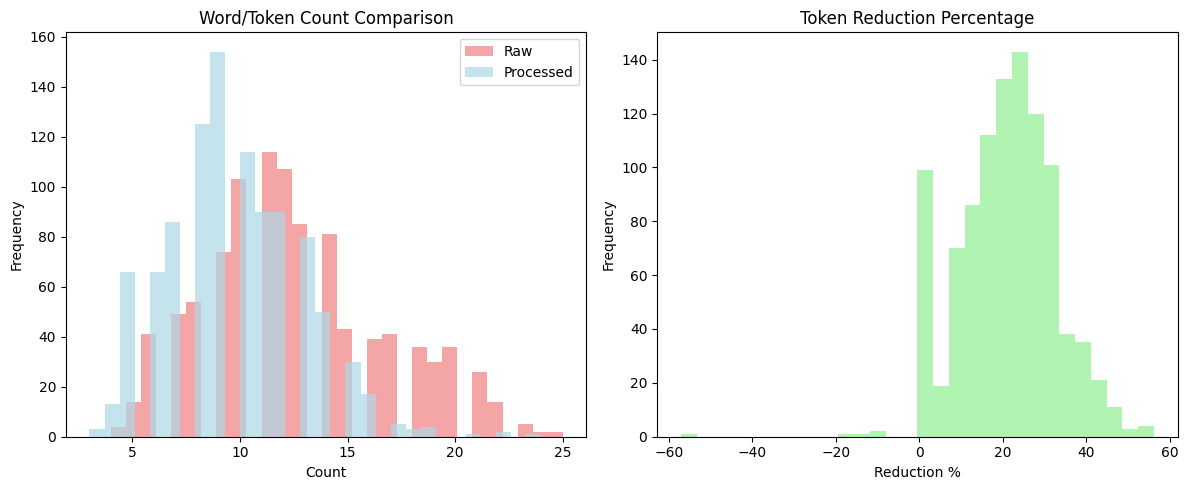

Average token reduction: 20.9%


In [8]:
# Compare word counts before and after preprocessing
raw_word_counts = [len(text.split()) for text in subset_texts]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(raw_word_counts, bins=30, alpha=0.7, label='Raw', color='lightcoral')
plt.hist(token_counts, bins=30, alpha=0.7, label='Processed', color='lightblue')
plt.title('Word/Token Count Comparison')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
reduction_ratio = [(raw - proc) / raw * 100 for raw, proc in zip(raw_word_counts, token_counts) if raw > 0]
plt.hist(reduction_ratio, bins=30, alpha=0.7, color='lightgreen')
plt.title('Token Reduction Percentage')
plt.xlabel('Reduction %')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Average token reduction: {np.mean(reduction_ratio):.1f}%")

## Vocabulary Analysis

In [9]:
# Flatten all tokens and analyze vocabulary
all_tokens = [token for tokens in processed_subset for token in tokens]
tokens_to_remove = preprocessor_stem.get_normalized_patterns()
# Remove specified tokens
all_tokens = [token for token in all_tokens if token not in tokens_to_remove]


vocab_counter = Counter(all_tokens)

print(f"Total tokens: {len(all_tokens):,}")
print(f"Unique tokens (vocabulary size): {len(vocab_counter):,}")
print(f"Vocabulary richness: {len(vocab_counter)/len(all_tokens):.4f}")

# Most common tokens
print(f"\nTop 20 most common tokens:")
for token, count in vocab_counter.most_common(20):
    print(f"{token}: {count}")

Total tokens: 8,516
Unique tokens (vocabulary size): 2,760
Vocabulary richness: 0.3241

Top 20 most common tokens:
target: 158
fed: 157
price: 154
bank: 132
stock: 132
cut: 81
raised: 76
the: 75
say: 74
buy: 62
rate: 61
new: 56
analyst: 52
market: 42
central: 41
coronavirus: 39
powell: 37
downgraded: 36
economy: 36
you: 35


In [10]:
tokens_to_remove

[' ',
 'COST',
 'URL',
 'HASHTAG',
 'USER',
 'TICKER',
 'EMOJI',
 '\\1\\2',
 '\\1',
 '',
 '',
 '']

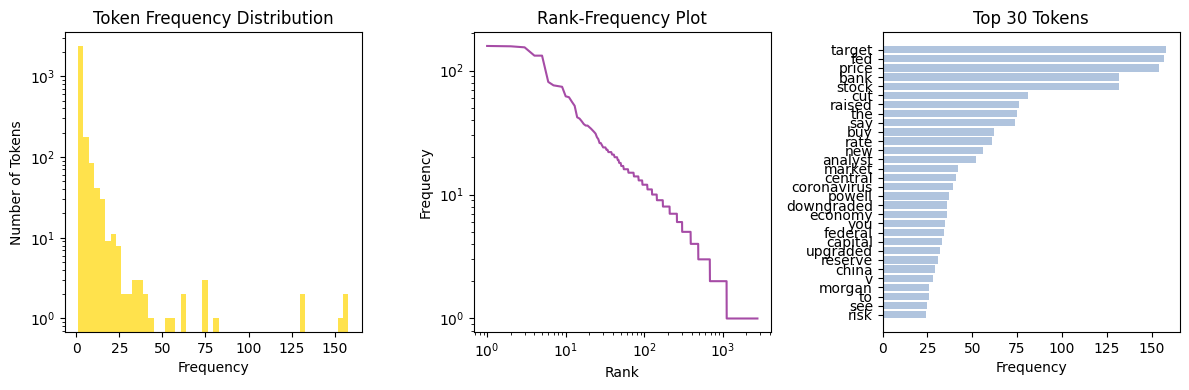

In [11]:
# Token frequency distribution
token_frequencies = list(vocab_counter.values())

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(token_frequencies, bins=50, alpha=0.7, color='gold')
plt.title('Token Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Number of Tokens')
plt.yscale('log')

plt.subplot(1, 3, 2)
# Rank-frequency plot (Zipf's law)
ranks = range(1, len(token_frequencies) + 1)
sorted_frequencies = sorted(token_frequencies, reverse=True)
plt.loglog(ranks, sorted_frequencies, alpha=0.7, color='purple')
plt.title('Rank-Frequency Plot')
plt.xlabel('Rank')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
# Top 30 tokens bar plot
top_tokens = vocab_counter.most_common(30)
tokens, counts = zip(*top_tokens)
plt.barh(range(len(tokens)), counts, color='lightsteelblue')
plt.yticks(range(len(tokens)), tokens)
plt.title('Top 30 Tokens')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [12]:
vocab_counter

Counter({'target': 158,
         'fed': 157,
         'price': 154,
         'bank': 132,
         'stock': 132,
         'cut': 81,
         'raised': 76,
         'the': 75,
         'say': 74,
         'buy': 62,
         'rate': 61,
         'new': 56,
         'analyst': 52,
         'market': 42,
         'central': 41,
         'coronavirus': 39,
         'powell': 37,
         'downgraded': 36,
         'economy': 36,
         'you': 35,
         'federal': 34,
         'capital': 33,
         'upgraded': 32,
         'reserve': 31,
         'china': 29,
         'v': 28,
         'morgan': 26,
         'to': 26,
         'see': 25,
         'risk': 24,
         'business': 24,
         'billion': 24,
         'growth': 23,
         'job': 23,
         'neutral': 22,
         'overweight': 22,
         'update': 22,
         'loan': 22,
         'may': 21,
         'bofa': 21,
         'uber': 21,
         'credit': 20,
         'outperform': 20,
         'in': 20,
         'in

This plot tests Zipf's Law, which states that in natural language:

The most frequent word appears about twice as often as the 2nd most frequent
Three times as often as the 3rd most frequent
And so on...
In a log-log plot, Zipf's Law appears as a straight line with negative slope (approximately -1).

Interpretation:
Straight diagonal line: Your text follows Zipf's Law (typical for natural language)
Curved or irregular line: Deviation from expected language patterns
Steep slope: High concentration of frequent words
Gentle slope: More even distribution of word frequencies
This analysis helps you understand the vocabulary distribution in your preprocessed text data and validate that your preprocessing maintains natural language characteristics.

## Word Clouds Comparison

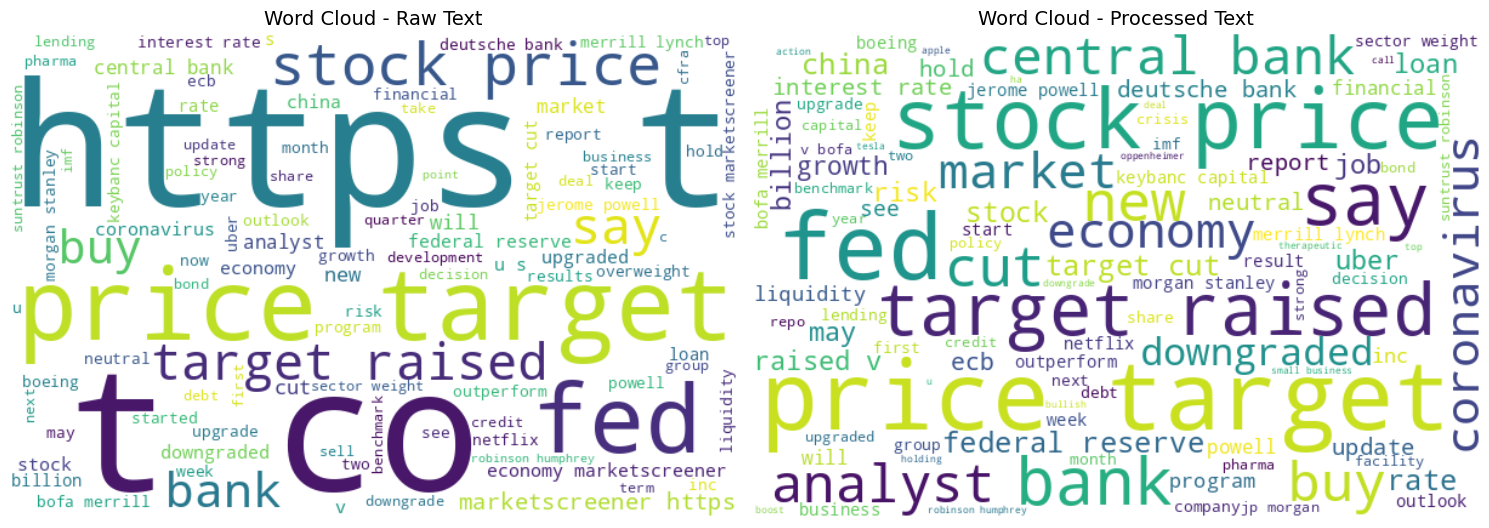

In [13]:
# Create word clouds for raw vs processed text
raw_text = ' '.join(subset_texts).lower()
processed_text = ' '.join(all_tokens)

plt.figure(figsize=(15, 6))

# Raw text word cloud
plt.subplot(1, 2, 1)
raw_wc = WordCloud(width=600, height=400, background_color='white', max_words=100).generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Raw Text', fontsize=14)

# Processed text word cloud
plt.subplot(1, 2, 2)
processed_wc = WordCloud(width=600, height=400, background_color='white', max_words=100).generate(processed_text)
plt.imshow(processed_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Processed Text', fontsize=14)

plt.tight_layout()
plt.show()

## Preprocessing Pattern Detection

In [14]:
# Test specific preprocessing patterns
test_patterns = [
    "Check out this amazing deal at $50.99! Visit https://example.com for more info #sale @company",
    "The stock $AAPL is trading at €150.00. What a wonderful day!!!",
    "Follow @username for updates. #investing #stocks www.example.com",
    "This costs $25,000 approximately. Really expensive!!!"
]

print("Pattern replacement testing:")
for i, text in enumerate(test_patterns, 1):
    processed = preprocessor_lemma.preprocess([text])[0]
    print(f"\n{i}. Original: {text}")
    print(f"   Processed: {' '.join(processed)}")

Pattern replacement testing:
Processing emojis with support level 1
ASCII cleaned text: Check out this amazing deal at COST  Visit URL for more info HASHTAG USER

1. Original: Check out this amazing deal at $50.99! Visit https://example.com for more info #sale @company
   Processed: check amazing deal COST visit URL info HASHTAG USER
Processing emojis with support level 1
ASCII cleaned text: The stock TICKER is trading at COST  What  wonderful day   

2. Original: The stock $AAPL is trading at €150.00. What a wonderful day!!!
   Processed: the stock TICKER trading COST what wonderful day
Processing emojis with support level 1
ASCII cleaned text: Follow USER for updates  HASHTAG HASHTAG ww example com

3. Original: Follow @username for updates. #investing #stocks www.example.com
   Processed: follow USER update HASHTAG HASHTAG ww example com
Processing emojis with support level 1
ASCII cleaned text: This costs COST approximately  Really expensive   

4. Original: This costs $25,000 appr

## Performance Analysis

In [15]:
import time

# Performance comparison between different preprocessing approaches
test_batch = data_train['text'].head(100).tolist()

# Test different configurations
configs = [
    ('Lemmatization only', Preprocessing(lemmatize=True, stem=False)),
    ('Stemming only', Preprocessing(lemmatize=False, stem=True)),
    ('Both', Preprocessing(lemmatize=True, stem=True)),
    ('Neither', Preprocessing(lemmatize=False, stem=False))
]

results = []
for name, preprocessor in configs:
    start_time = time.time()
    processed = preprocessor.preprocess(test_batch)
    end_time = time.time()
    
    avg_tokens = np.mean([len(tokens) for tokens in processed])
    processing_time = end_time - start_time
    
    results.append({
        'Configuration': name,
        'Processing Time (s)': processing_time,
        'Avg Tokens per Text': avg_tokens,
        'Texts per Second': len(test_batch) / processing_time
    })

results_df = pd.DataFrame(results)
print("Performance Comparison:")
print(results_df.round(3))

/Users/joanaesteves/Desktop/MDSAA-DS/S2/T4/TM/.TM_Project/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:177: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


ASCII cleaned text: TICKER   JPMorgan reels in expectations on Beyond Meat URL
ASCII cleaned text: TICKER TICKER   Nomura points to bookings weakness at Carnival and Royal Caribbean URL
ASCII cleaned text: TICKER   Cemex cut at Credit Suisse  JP  Morgan on weak building outlook URL
ASCII cleaned text: TICKER  BTIG Research cuts to Neutral URL
ASCII cleaned text: TICKER   Funko slides after Piper Jaffray PT cut URL
ASCII cleaned text: TICKER   TechnipFMC downgraded at Berenberg but called Top Pick at Deutsche Bank URL
ASCII cleaned text: TICKER   GM loses  bull URL
ASCII cleaned text: TICKER  Deutsche Bank cuts to Hold URL
ASCII cleaned text: TICKER  Cowen cuts to Market Perform
ASCII cleaned text: TICKER TICKER TICKER   Trendforce cuts iPhone estimate after Foxconn delay URL
ASCII cleaned text: TICKER   Moody warns on HarleyDavidson URL
ASCII cleaned text: TICKER   Citing aero ties  Wells slashes PT on Hexcel URL
ASCII cleaned text: TICKER   Intelsat cut to Market Perform at Raymond Ja

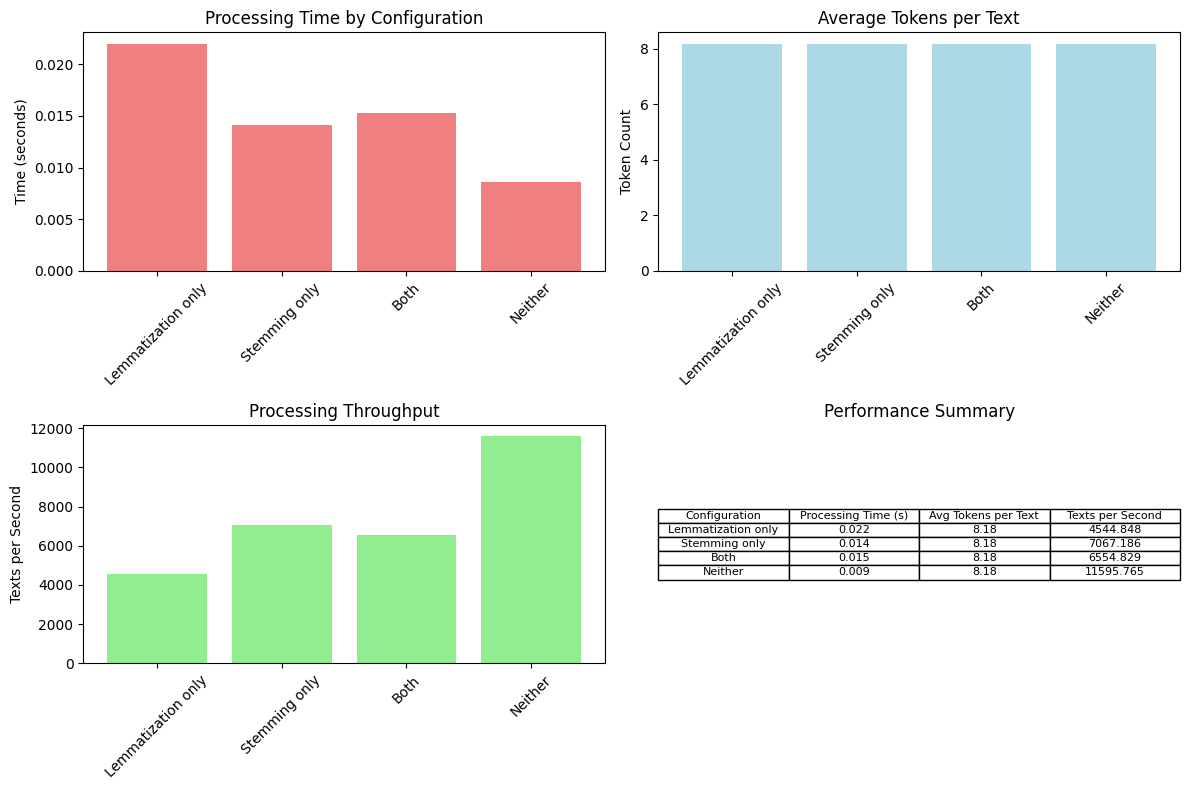

In [16]:
# Visualize performance results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Processing time
ax1.bar(results_df['Configuration'], results_df['Processing Time (s)'], color='lightcoral')
ax1.set_title('Processing Time by Configuration')
ax1.set_ylabel('Time (seconds)')
ax1.tick_params(axis='x', rotation=45)

# Average tokens
ax2.bar(results_df['Configuration'], results_df['Avg Tokens per Text'], color='lightblue')
ax2.set_title('Average Tokens per Text')
ax2.set_ylabel('Token Count')
ax2.tick_params(axis='x', rotation=45)

# Throughput
ax3.bar(results_df['Configuration'], results_df['Texts per Second'], color='lightgreen')
ax3.set_title('Processing Throughput')
ax3.set_ylabel('Texts per Second')
ax3.tick_params(axis='x', rotation=45)

# Summary table
ax4.axis('tight')
ax4.axis('off')
table = ax4.table(cellText=results_df.round(3).values, 
                  colLabels=results_df.columns,
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
ax4.set_title('Performance Summary')

plt.tight_layout()
plt.show()

## Summary and Recommendations

In [17]:
print("=== PREPROCESSING ANALYSIS SUMMARY ===")
print(f"\n Dataset Overview:")
print(f"   • Total samples analyzed: {subset_size}")
print(f"   • Average raw word count: {np.mean(raw_word_counts):.1f}")
print(f"   • Average processed token count: {np.mean(token_counts):.1f}")

print(f"\n Vocabulary Analysis:")
print(f"   • Total tokens: {len(all_tokens):,}")
print(f"   • Unique vocabulary: {len(vocab_counter):,}")
print(f"   • Vocabulary richness: {len(vocab_counter)/len(all_tokens):.4f}")

print(f"\n Performance Insights:")
best_throughput = results_df.loc[results_df['Texts per Second'].idxmax()]
print(f"   • Fastest configuration: {best_throughput['Configuration']}")
print(f"   • Best throughput: {best_throughput['Texts per Second']:.1f} texts/second")

print(f"\n Recommendations:")
print(f"   • Average token reduction: {np.mean(reduction_ratio):.1f}%")

=== PREPROCESSING ANALYSIS SUMMARY ===

 Dataset Overview:
   • Total samples analyzed: 1000
   • Average raw word count: 12.6
   • Average processed token count: 9.8

 Vocabulary Analysis:
   • Total tokens: 8,516
   • Unique vocabulary: 2,760
   • Vocabulary richness: 0.3241

 Performance Insights:
   • Fastest configuration: Neither
   • Best throughput: 11595.8 texts/second

 Recommendations:
   • Average token reduction: 20.9%
